# Настройка среды

In [1]:
import os
import sys
sys.path.append(os.path.abspath("../.."))

In [2]:
from belashovplot import TiledPlot
from utilities import *
from utilities.filters import Gaussian, Window
from utilities.training import train, confusion
from elements.abstracts import AbstractModulator
from elements.modulators import Lens, PhaseModulator, AmplitudeModulator
from elements.propagators import FurrierPropagation, ConvolutionalPropagation
from elements.composition import CompositeModel, HybridModel
from elements.wrappers import CudaMemoryChunker, Incoherent
from elements.detectors import ClassificationDetectors, MatrixDetectors
from elements.simple import AdjustSize
from parameters import FigureWidthHeight, FontLibrary
from tqdm import tqdm
from math import sin, sqrt
import torch
import torchvision
import numpy
import timm
import pandas
from copy import deepcopy
from PIL import Image
from itertools import product

In [3]:
FontLibrary.Fonts.PlotTitle.FontSize = 16

FontLibrary.Fonts.DescriptionLeft.FontSize = 12
FontLibrary.Fonts.DescriptionLeft.FontWeight = 'bold'
FontLibrary.Fonts.DescriptionLeft.FontStyle = 'italic'

FontLibrary.Fonts.DescriptionBottom.FontSize = 10
FontLibrary.Fonts.DescriptionBottom.FontWeight = 'bold'
FontLibrary.Fonts.DescriptionBottom.FontStyle = 'italic'

FontLibrary.Fonts.DescriptionTop.FontSize = 10
FontLibrary.Fonts.DescriptionTop.FontWeight = 'bold'
FontLibrary.Fonts.DescriptionTop.FontStyle = 'italic'

FontLibrary.Fonts.ColumnDescriptionTop.FontSize = 9
FontLibrary.Fonts.ColumnDescriptionBottom.FontSize = 9
FontLibrary.Fonts.RowDescriptionLeft.FontSize = 9
FontLibrary.Fonts.RowDescriptionRight.FontSize = 9
FontLibrary.Fonts.AxisX.FontSize = 8
FontLibrary.Fonts.AxisY.FontSize = 8

FontLibrary.Fonts.GraphTitle.FontSize = 10

FigureWidthHeight = (6.69291, 10.1181-1.0)

In [4]:
device = torch.device(7 if torch.cuda.is_available() else 'cpu')
print('Используемый девайс:', torch.cuda.get_device_name(device) if torch.cuda.is_available() else 'ЦП')

Используемый девайс: NVIDIA A100-SXM4-80GB


# Определение параметров модели

In [5]:
# Предпочтительные параметры
size = 9.765625E-6/2.0
near_N = 1024 #2004 #1336
near_length = 5.0E-3
wavelength = 500.0E-9
masks_amount = 1
distance = 300.0E-3

# Параметры обучения
batch_size = 30
learning_rate = 0.009854
loss_function_proportion = 0.609798
optimizer_type_name = 'Adam'
optimizer_types_list = {'Adam':torch.optim.Adam, 'SGD':torch.optim.SGD, 'RMSprop':torch.optim.RMSprop, 'Adagrad':torch.optim.Adagrad}

# Параметры когерентности
spatial_coherence = 100.0E-6
time_coherence = 10.0E-9
time_relaxation = 1.0E-6
mean_samples = 20

# Вычисляемые параметры
pixels = upper_integer(near_length/size)
length = pixels * size
cppp = int(near_N * size / length)
N = upper_integer(length*cppp / size) 

print(f"Длинна волны:                             {engineering(wavelength, 'м')}")
print(f"Количество вычислительных пикселей:       {N}")
print(f"Количество пикселей маски:                {pixels}")
print(f"Размер оптических элементов:              {engineering(length, 'м')}")
print(f"Размер пикселя маски:                     {engineering(length/pixels, 'м')}")
print(f"Расстояние между слоями:                  {engineering(distance, 'м')}")

print(f"Временная когерентность:                  {engineering(time_coherence, 'с')}")
print(f"Время релаксации:                         {engineering(time_relaxation, 'c')}")
print(f"Пространственная когерентность:           {engineering(spatial_coherence, 'м')}")
print(f"Количество усреднений:                    {mean_samples}")

print(f"Размер батча:                             {batch_size}")
print(f"Тип оптимизатора:                         {optimizer_type_name}")

Длинна волны:                             500.0 нм
Количество вычислительных пикселей:       1024
Количество пикселей маски:                1024
Размер оптических элементов:              5.0 мм
Размер пикселя маски:                     4.883 мкм
Расстояние между слоями:                  300.0 мм
Временная когерентность:                  10.0 нс
Время релаксации:                         1.0 мкc
Пространственная когерентность:           100.0 мкм
Количество усреднений:                    20
Размер батча:                             30
Тип оптимизатора:                         Adam


# Инициализация моделей

In [6]:
# Модуль некогерентности
incoherent = Incoherent(spatial_coherence, time_coherence, time_relaxation, mean_samples, N, length)
incoherent_encoder, incoherent_decoder = incoherent.pair()
incoherent_encoder, incoherent_decoder = incoherent_encoder.to(device), incoherent_decoder.to(device)
incoherent.sample()

# Оптические модели
propagation = FurrierPropagation(N, length, wavelength, 1.0, 0.0, distance, 0.4)
phase_modulator = PhaseModulator(N, length, pixels)
# with torch.no_grad():
    # next(iter(phase_modulator.parameters())).copy_(torch.zeros_like(next(iter(phase_modulator.parameters()))))
optical_incoherent = CompositeModel(incoherent_encoder, propagation, phase_modulator, propagation, incoherent_decoder).to(device)
optical_coherent = CompositeModel(propagation, phase_modulator, propagation).to(device)

# Набор данных
dataset = Dataset('CIFAR10', batch_size, N, N, torch.complex64, threads=8, preload=10)
# dataset.padding(surface_ratio=0.3)
dataset.reference.mirrored()
dataset.load.train()
dataset.load.test()

# Тип оптимизатора
optimizer_type = optimizer_types_list[optimizer_type_name]

# Визуализация набора данных и параметров модели

Out of Memory Error, split:2
Out of Memory Error, split:4
Out of Memory Error, split:8
Out of Memory Error, split:16
Out of Memory Error, resizing


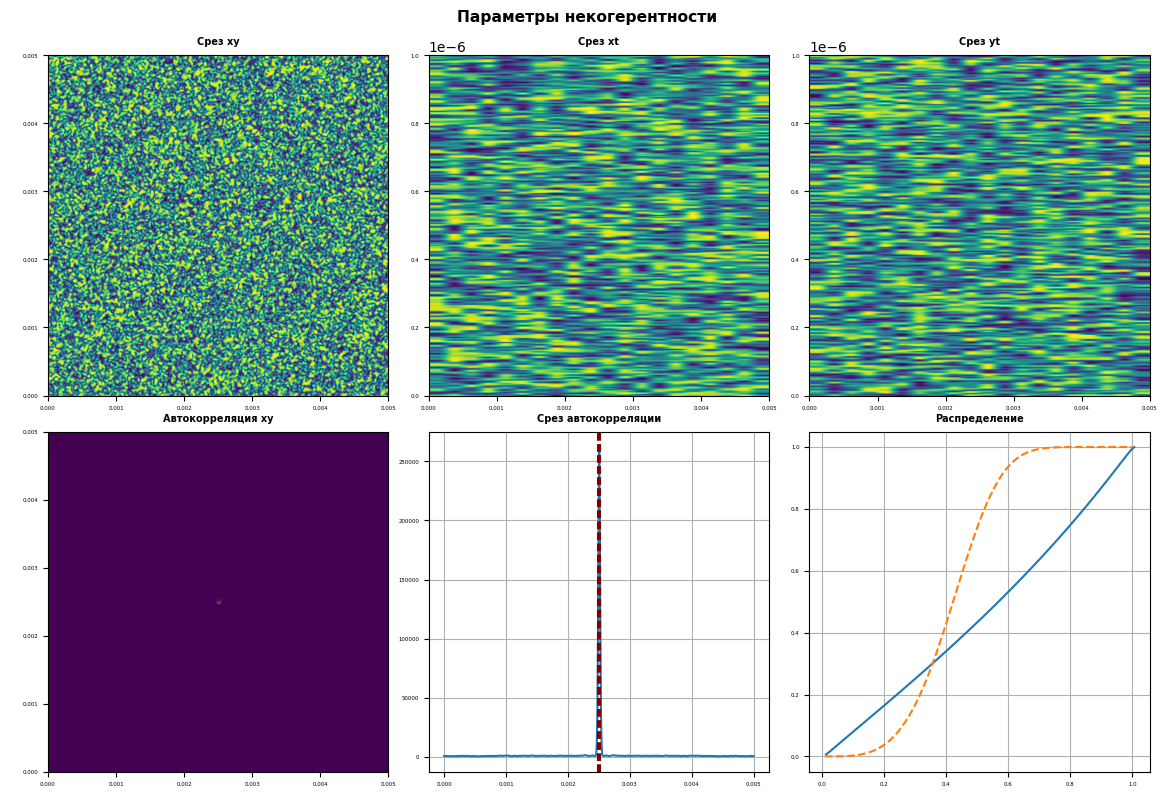

In [7]:
incoherent.show()

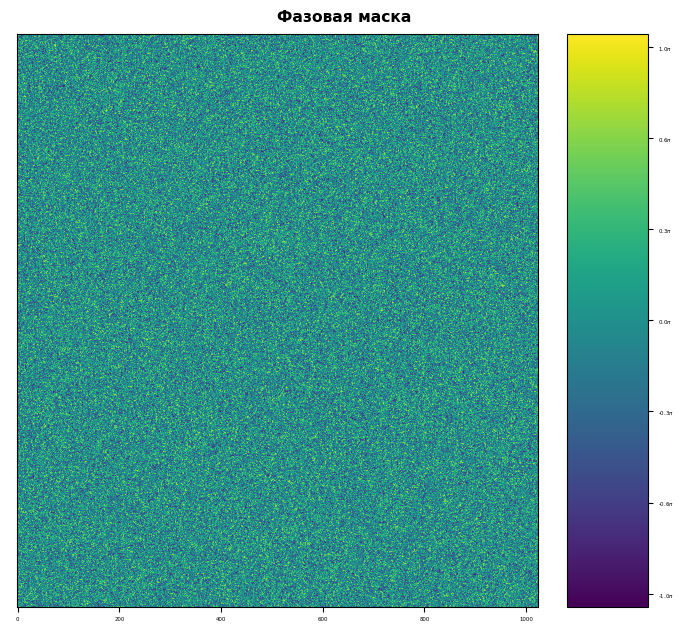

In [8]:
import matplotlib.pyplot as plt

plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary

plot.title("Фазовая маска")

axes = plot.axes.add((0,0),(4,5))
# axes.xaxis.set_visible(False)
axes.yaxis.set_visible(False)
image = axes.imshow(optical_incoherent.element(2).multiplier().angle().squeeze(), aspect='auto')
axes_ = plot.axes.add((5,0),(5,5))
bar = plt.colorbar(image, cax=axes_, shrink=0.7, format=lambda x,i: f"{round(x/3.1415,1)}$\pi$", location='right')

plot.show()

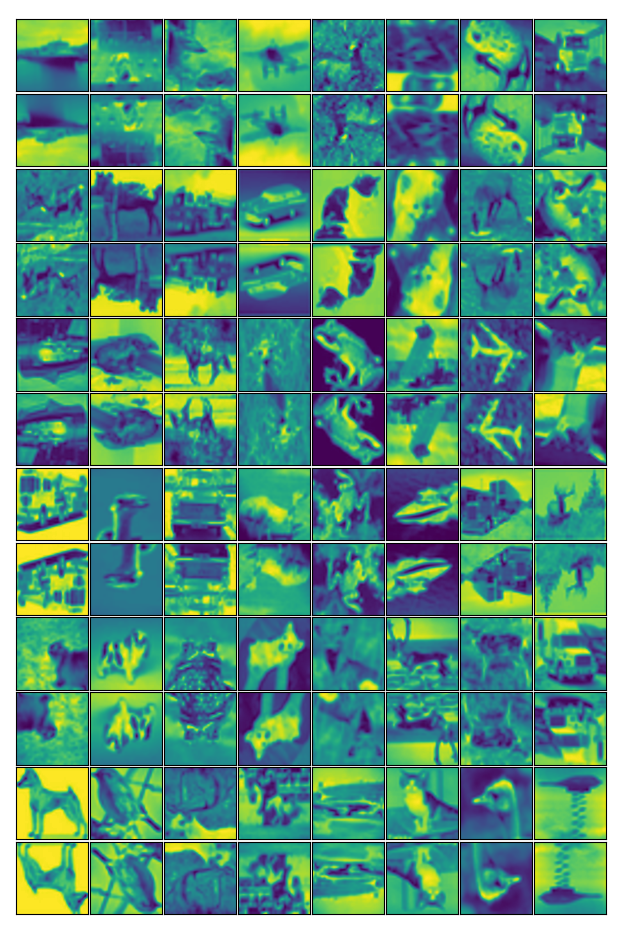

In [9]:
data_cols = 8
data_rows = 6
plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary

for (image, image_), (col,row) in zip(dataset.train, product(range(data_cols),range(data_rows))):
    axes = plot.axes.add(col,2*row)
    axes.xaxis.set_visible(False)
    axes.yaxis.set_visible(False)
    axes.imshow(image[0].squeeze().abs(), aspect='auto')


    axes = plot.axes.add(col,2*row+1)
    axes.xaxis.set_visible(False)
    axes.yaxis.set_visible(False)
    axes.imshow(image_[0].squeeze().abs(), aspect='auto')
plot.show()

# Обучение модели

In [ ]:
torch.cuda.empty_cache()

loss_history = []
gradients_history = []
parameters_history = []

optimizer = optimizer_type(optical_incoherent.parameters(), lr=0.01)
optical_incoherent = optical_incoherent.to(device)
loss_function = ImageComparisonMSE(normilize=True)

optical_incoherent.train()
for epoch in range(10):
    iterator = tqdm(dataset.train, bar_format="{l_bar}{bar} | {n_fmt}/{total_fmt} | {elapsed}m - {remaining}m")
    for n, (images, references) in enumerate(iterator):
        images, references = images.to(device), references.to(device)
        results = optical_incoherent.forward(images)
    
        loss = loss_function(results, references)
        loss_history.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        
        states = list(optical_incoherent.parameters())
        for i, state in enumerate(states):
            states[i] = state.grad.clone().detach().cpu()
        gradients_history.append(states)
        parameters_history.append([param.clone().detach().cpu() for param in optical_incoherent.parameters()])
        
        optimizer.step()
    
        iterator.set_description(f"Loss: {scientific(loss.item(),space='')} ")
        iterator.refresh()
    
        # if n >= 300:
            # break
optical_incoherent.eval()

Loss: 97.007·10⁻³ : 100%|███████████████████████████████████████████████████████████████████████████████ | 1667/1667 | 56:55m - 00:00m
Loss: 89.913·10⁻³ :  85%|████████████████████████████████████████████████████▋          | 1417/1667 | 48:25m - 08:36m

# Визуализация

In [ ]:
amount = 4
number = 1
if parameters_history[0][number].numel() > amount:
    random_indexes = numpy.random.randint(0, parameters_history[0][number].numel(), amount)
else:
    random_indexes = numpy.arange(0, parameters_history[0][number].numel())
progresses = []
for index in random_indexes:
    progress = numpy.zeros(len(parameters_history))
    for i, parameters in enumerate(parameters_history):
        progress[i] = parameters[number].flatten()[index]
    progresses.append(progress)

plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary

axes = plot.axes.add(0,0)
axes.grid(True)
for index, progress in zip(random_indexes, progresses):
    axes.plot(progress, label=f"Параметр с индексом {index}")
axes.legend()

plot.show()

In [ ]:
amount = 4
number = 0
if parameters_history[0][number].numel() > amount:
    random_indexes = numpy.random.randint(0, parameters_history[0][number].numel(), amount)
else:
    random_indexes = numpy.arange(0, parameters_history[0][number].numel())
progresses = []
for index in random_indexes:
    progress = numpy.zeros(len(parameters_history))
    for i, parameters in enumerate(parameters_history):
        progress[i] = parameters[number].flatten()[index]
    progresses.append(progress)

plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary

axes = plot.axes.add(0,0)
axes.grid(True)
for index, progress in zip(random_indexes, progresses):
    axes.plot(progress, label=f"Параметр с индексом {index}")
axes.legend()

plot.show()

In [ ]:
with torch.no_grad():
    model = optical_incoherent
    
    ratio = 0.3
    images = []
    dataset = Dataset('STL10', 1, N, N, torch.complex64, threads=1, preload=10)
    dataset.padding(surface_ratio=ratio)
    images.append(next(iter(dataset.test))[0])
    dataset = Dataset('CIFAR10', 1, N, N, torch.complex64, threads=1, preload=10)
    dataset.padding(surface_ratio=ratio)
    images.append(next(iter(dataset.test))[0])
    dataset = Dataset('MNIST', 1, N, N, torch.complex64, threads=1, preload=10)
    dataset.padding(surface_ratio=ratio)
    images.append(next(iter(dataset.test))[0])
    temp = interpolate(torch.mean(torchvision.transforms.functional.pil_to_tensor(Image.open('../../figures/MSU.jpg')).to(torch.float32), dim=0).unsqueeze(0).unsqueeze(0), (N,N))
    images.append(temp)
    labels = ['STL10', 'CIFAR10', 'MNIST', 'Высокое разрешение']
    
    plot = TiledPlot(*FigureWidthHeight)
    plot.FontLibrary = FontLibrary
    plot.description.column.top('Исходное изображение', 0)
    plot.description.column.top('Полученное изображение', 1)
    
    for row, (image, label) in enumerate(zip(images, labels)):
        plot.description.row.left(label, row)
        
        image = image.to(device)
        result = model.forward(image)
        image, result = image.clone().detach().squeeze().abs().cpu(), result.clone().detach().squeeze().abs().cpu()

        axes = plot.axes.add(0, row)
        axes.xaxis.set_visible(False)
        axes.yaxis.set_visible(False)
        axes.imshow(image, aspect='auto')

        axes = plot.axes.add(1,row)
        axes.xaxis.set_visible(False)
        axes.yaxis.set_visible(False)
        axes.imshow(result, aspect='auto')
    
    plot.show()

In [ ]:
incoherent.show()

In [ ]:
import matplotlib.pyplot as plt

plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary

plot.title("Фазовая маска")

axes = plot.axes.add((0,0),(4,5))
# axes.xaxis.set_visible(False)
axes.yaxis.set_visible(False)
image = axes.imshow(optical_incoherent.element(2).multiplier().angle().squeeze(), aspect='auto')
axes_ = plot.axes.add((5,0),(5,5))
bar = plt.colorbar(image, cax=axes_, shrink=0.7, format=lambda x,i: f"{round(x/3.1415,1)}$\pi$", location='right')

plot.show()

In [ ]:
plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary
plot.width_to_height(2.0)
plot.title("Зависимость ошибки от номера итерации")

axes = plot.axes.add(0,0)
axes.grid(True)
axes.plot(loss_history)

plot.show()

In [ ]:
amount = 4
number = 1
if gradients_history[0][number].numel() > amount:
    random_indexes = numpy.random.randint(0, gradients_history[0][number].numel(), amount)
else:
    random_indexes = numpy.arange(0, gradients_history[0][number].numel())
progresses = []
means = []
ameans = []
for index in random_indexes:
    progress = numpy.zeros(len(gradients_history))
    for i, gradients in enumerate(gradients_history):
        progress[i] = gradients[number].flatten()[index]
    progresses.append(progress)
    means.append(numpy.mean(progress))
    ameans.append(numpy.mean(numpy.abs(progress)))

plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary

axes = plot.axes.add(0,0)
axes.grid(True)
for index, progress, mean, amean in zip(random_indexes, progresses, means, ameans):
    axes.plot(progress, label=f"Параметр №{index}, m:{scientific(mean,'',1,space='')}, am:{scientific(amean,'',1,space='')}")
axes.legend()
axes.xaxis.set_tick_params(labelsize=10)
axes.yaxis.set_tick_params(labelsize=10)


plot.show()

In [ ]:
amount = 4
number = 1
if gradients_history[0][number].numel() > amount:
    random_indexes = numpy.random.randint(0, gradients_history[0][number].numel(), amount)
else:
    random_indexes = numpy.arange(0, gradients_history[0][number].numel())
progresses = []
means = []
ameans = []
for index in random_indexes:
    progress = numpy.zeros(len(gradients_history))
    for i, gradients in enumerate(gradients_history):
        progress[i] = gradients[number].flatten()[index]
    progresses.append(progress)
    means.append(numpy.mean(progress))
    ameans.append(numpy.mean(numpy.abs(progress)))

plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary

axes = plot.axes.add(0,0)
axes.grid(True)
for index, progress, mean, amean in zip(random_indexes, progresses, means, ameans):
    axes.plot(progress, label=f"Параметр №{index}, m:{scientific(mean,'',1,space='')}, am:{scientific(amean,'',1,space='')}")
axes.legend()
axes.xaxis.set_tick_params(labelsize=10)
axes.yaxis.set_tick_params(labelsize=10)


plot.show()

In [ ]:
number = 1
norm_history = []
min_norm = 1.0E+160
min_norm_index = 0
current_parameters = list(optical_incoherent.parameters())[number].detach().cpu()
for i, parameters in enumerate(parameters_history):
    parameters = parameters[number]
    norm = (parameters - current_parameters).norm()
    norm_history.append(norm.item())
    if norm < min_norm:
        min_norm = norm
        min_norm_index = i

print(f"Minimum norm index is {min_norm_index}|{len(parameters_history)-1}, norm = {min_norm}")
print("Current parameters:", current_parameters, sep='\n')
print("Closest parameters:", parameters_history[min_norm_index][number], sep='\n')

plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary
plot.width_to_height(3.0)

axes = plot.axes.add(0,0)
axes.grid(True)
axes.plot(norm_history)

plot.show()